# TFM : Aplicación de *Machine Learning* para la Gestión de Inventarios
> Erendira Teresa Navarro García

## Cross Validation 
Para elección del modelo

In [ ]:
# Python 3 environment Google Colab
import pandas as pd
import os
import csv
import datetime as datetime
import pywt
import json 
import sklearn
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pylab as plab
from datetime import datetime
from dateutil.parser import parse
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, mean_squared_log_error, median_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Lectura de datos

In [ ]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
df_tfm = pd.read_csv('/content/drive/MyDrive/Files_TFM/export_data_tfm.csv', 
                     parse_dates=['fecha'], date_parser=dateparse, dtype={'sku': str})
df_tfm = df_tfm.sort_values(by='fecha').set_index('fecha')

In [ ]:
os.chdir("/content/drive/MyDrive/Files_TFM/")
print(os.getcwd())

/content/drive/MyDrive/Files_TFM


### Preparación de los datos

In [ ]:
# Función para creación de nuevas variables - lag de 1 a 7 y diferencia en ventas del día anterior y del día previo
def features(dataset_t, columns_y):
  for i in range(1,8):
    dataset_t.loc[:,'lag'+str(i)] = dataset_t.loc[:,columns_y].shift(i)
    if i in [1,2]:
      dataset_t.loc[:,'diff'+str(i)] = dataset_t.loc[:,columns_y].diff(i)
  # Eliminar NAs
  dataset_t = dataset_t.dropna()
  return dataset_t

# Separar dataset y crear nuevas variables
def split_dataset(dataset, split_per, column_y):
  data_train, data_test = train_test_split(dataset, test_size=split_per, shuffle=False)
  data_train_total = features(data_train,column_y)
  data_test_total = features(data_test,column_y)
  y_train = data_train_total.loc[:,column_y]
  X_train = data_train_total.drop(columns=column_y)
  y_test = data_test_total.loc[:,column_y]
  X_test = data_test_total.drop(columns=column_y)
  return X_train, X_test, y_train, y_test

### Modelos

In [ ]:
# Variables a utilizar en los modelos
columns_ok = ["bolOpen","promo"]#["bolOpen","promo","bolHoliday"]
columns_to_scale  = ['lag'+str(i) for i in [1,2,7]] + ['diff'+str(i) for i in [1,2]] #['lag'+str(i) for i in range(1,8)]
y_to_scale  = ["udsVentaT"]
# Elección de modelos
models = []
models.append(('RF', RandomForestRegressor(random_state=0)))
models.append(('SVR', SVR()))
models.append(('NN', MLPRegressor(random_state=0, max_iter=2000)))

In [ ]:
def cv_analisis(y_target):
  df_cv_modelos = pd.DataFrame([],columns =["sku", "model", "mean_cv", "std_cv"])
  df_resultados = pd.DataFrame([],columns =["sku", "best_model", "best_cv_mean"])
  for i in range (1,51):
    #dataset filtrado por sku
    dataset_sku = df_tfm[(df_tfm["sku"] == str(i))].drop(columns=["udsStock","label"])
    #split dataset
    X_train, X_test, y_train, y_test = split_dataset(dataset_sku, 0.3, y_target)
    #Scalers
    mm_train_cv = MinMaxScaler(feature_range = (0,1))
    mm_ytrain_cv = MinMaxScaler(feature_range = (0,1))
    # Escalamiento de datos
    y_train = mm_ytrain_cv.fit_transform(y_train.reset_index()[[y_target]]).ravel()
    X_tmp  = mm_train_cv.fit_transform(X_train.reset_index()[columns_to_scale]) 
    # Tabla X
    X_train = np.concatenate([X_tmp , X_train.reset_index()[columns_ok].values], axis=1)
    #### CV
    results = []
    names = []
    mean_cv = []
    std_cv = []
    for name, model in models:
      # TimeSeries Cross validation
      tscv = TimeSeriesSplit(n_splits=8)
      cv_results = cross_val_score(model, X_train, y_train, cv = tscv, scoring = "r2")
      results.append(cv_results)
      names.append(name)
      mean_cv.append(cv_results.mean())
      std_cv.append(cv_results.std())
    df_cv = pd.DataFrame({"model":names,"mean_cv":mean_cv, "std_cv":std_cv})
    df_cv["sku"] = str(i)
    df_cv = df_cv[["sku","model", "mean_cv", "std_cv"]]
    df_cv_modelos = df_cv_modelos.append(df_cv, ignore_index = True)
    modelo_max = df_cv[df_cv.mean_cv == np.max(df_cv.mean_cv)].model.values[0]
    valor_max = df_cv[df_cv.mean_cv == np.max(df_cv.mean_cv)].mean_cv.values[0]
    df = pd.DataFrame([[i,modelo_max,valor_max]], columns =["sku", "best_model", "best_cv_mean"])
    df_resultados = df_resultados.append(df, ignore_index = True)
  return df_cv_modelos, df_resultados

In [ ]:
df_cv, df_result = cv_analisis("udsVentaT")

In [ ]:
cv_resumen = df_result.groupby("best_model")["sku"].count().reset_index()
cv_resumen['per'] = 100 * cv_resumen["sku"] / cv_resumen["sku"].sum()
print(tabulate(cv_resumen.set_index("best_model"), headers=cv_resumen.columns, tablefmt='latex'))

\begin{tabular}{lrr}
\hline
 best\_model   &   sku &   per \\
\hline
 NN           &    21 &    42 \\
 RF           &    29 &    58 \\
\hline
\end{tabular}


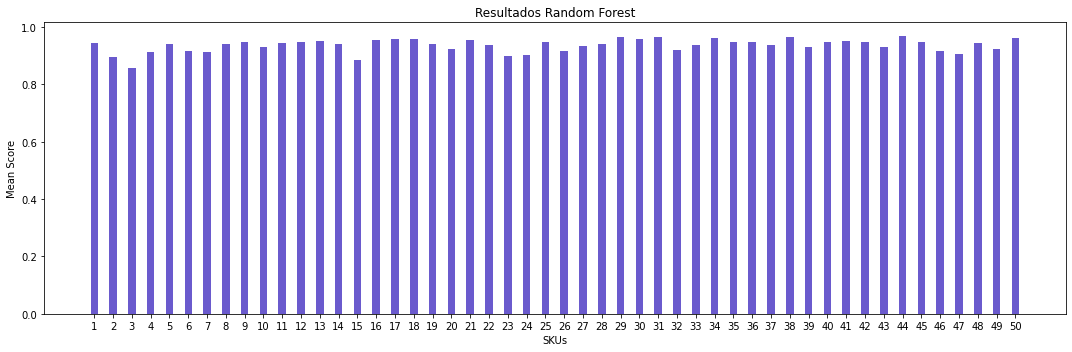

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,5))
plor_bar = plt.bar(df_cv.loc[df_cv["model"] == "RF","sku"], df_cv.loc[df_cv["model"] == "RF","mean_cv"], color ='slateblue',
        width = 0.4)
plt.xlabel("SKUs")
plt.ylabel("Mean Score")
plt.title("Resultados Random Forest")
plt.tight_layout()
plt.savefig("Random_Forest_CV_Resultados.png", dpi=300, bbox_inches='tight')

In [ ]:
print(tabulate(df_cv[df_cv["model"] == "RF"].set_index("sku"), headers=df_cv.columns, tablefmt='latex'))

\begin{tabular}{rlrr}
\hline
   sku & model   &   mean\_cv &    std\_cv \\
\hline
     1 & RF      &  0.945199 & 0.0525544 \\
     2 & RF      &  0.893807 & 0.0619995 \\
     3 & RF      &  0.85836  & 0.192354  \\
     4 & RF      &  0.913312 & 0.101476  \\
     5 & RF      &  0.942168 & 0.0522516 \\
     6 & RF      &  0.916501 & 0.0753538 \\
     7 & RF      &  0.913828 & 0.130224  \\
     8 & RF      &  0.941494 & 0.0543672 \\
     9 & RF      &  0.949079 & 0.0519505 \\
    10 & RF      &  0.93047  & 0.0805601 \\
    11 & RF      &  0.944879 & 0.0485716 \\
    12 & RF      &  0.948547 & 0.0431289 \\
    13 & RF      &  0.949507 & 0.0558509 \\
    14 & RF      &  0.941063 & 0.0819551 \\
    15 & RF      &  0.88647  & 0.116781  \\
    16 & RF      &  0.954484 & 0.0401543 \\
    17 & RF      &  0.957052 & 0.0413538 \\
    18 & RF      &  0.956736 & 0.0370731 \\
    19 & RF      &  0.939126 & 0.0558723 \\
    20 & RF      &  0.922064 & 0.0926404 \\
    21 & RF      &  0.953346 & 0.05022

In [ ]:
print(tabulate(df_cv[df_cv["model"] == "NN"].set_index("sku"), headers=df_cv.columns, tablefmt='latex'))

\begin{tabular}{rlrr}
\hline
   sku & model   &   mean\_cv &    std\_cv \\
\hline
     1 & NN      &  0.959027 & 0.0588858 \\
     2 & NN      &  0.783419 & 0.312151  \\
     3 & NN      &  0.599115 & 0.819494  \\
     4 & NN      &  0.902369 & 0.145298  \\
     5 & NN      &  0.96766  & 0.0387695 \\
     6 & NN      &  0.932443 & 0.0931288 \\
     7 & NN      &  0.859266 & 0.33822   \\
     8 & NN      &  0.960127 & 0.0625878 \\
     9 & NN      &  0.91589  & 0.133415  \\
    10 & NN      &  0.892507 & 0.140182  \\
    11 & NN      &  0.944687 & 0.05035   \\
    12 & NN      &  0.977257 & 0.0302072 \\
    13 & NN      &  0.962008 & 0.053308  \\
    14 & NN      &  0.963726 & 0.0596735 \\
    15 & NN      &  0.824955 & 0.235875  \\
    16 & NN      &  0.925135 & 0.13043   \\
    17 & NN      &  0.957246 & 0.0548028 \\
    18 & NN      &  0.980009 & 0.0299675 \\
    19 & NN      &  0.893526 & 0.179847  \\
    20 & NN      &  0.814011 & 0.39937   \\
    21 & NN      &  0.86132  & 0.32051

In [ ]:
print(tabulate(df_cv[df_cv["model"] == "SVR"].set_index("sku"), headers=df_cv.columns, tablefmt='latex'))

\begin{tabular}{rlrr}
\hline
   sku & model   &   mean\_cv &    std\_cv \\
\hline
     1 & SVR     &  0.874513 & 0.117869  \\
     2 & SVR     &  0.785547 & 0.20913   \\
     3 & SVR     &  0.805464 & 0.225666  \\
     4 & SVR     &  0.873265 & 0.115353  \\
     5 & SVR     &  0.877938 & 0.0831911 \\
     6 & SVR     &  0.869512 & 0.0707088 \\
     7 & SVR     &  0.903634 & 0.103327  \\
     8 & SVR     &  0.838436 & 0.165863  \\
     9 & SVR     &  0.870526 & 0.0703152 \\
    10 & SVR     &  0.851129 & 0.0883772 \\
    11 & SVR     &  0.885707 & 0.0632405 \\
    12 & SVR     &  0.896863 & 0.0655079 \\
    13 & SVR     &  0.911452 & 0.0577851 \\
    14 & SVR     &  0.838607 & 0.200192  \\
    15 & SVR     &  0.735921 & 0.247044  \\
    16 & SVR     &  0.851073 & 0.0923924 \\
    17 & SVR     &  0.816697 & 0.0964994 \\
    18 & SVR     &  0.879398 & 0.108775  \\
    19 & SVR     &  0.873077 & 0.0861133 \\
    20 & SVR     &  0.820372 & 0.122564  \\
    21 & SVR     &  0.787712 & 0.31540

In [ ]:
df_cv.to_csv('tabla_cross_validation.csv', index=False)